## ARIMAX

This script fits an ARIMAX models to our data to nowcast GDP, using our non-GDP variables as exogenous regressors, and incorporating an autoregressive component (previous values of GDP), moving average component (previous residuals of GDP), and differencing (accounts for non-stationarity). 

First, let's load the packages we need.

In [132]:
# PACKAGES
import pandas as pd
import numpy as np
import statsmodels.api as sm # for arimax
import pmdarima as pm # for arimax with AIC-based automatic order selection
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


Load data.

In [133]:
data = pd.read_csv("../data/data_wpk.csv")

data2 = pd.read_csv("../code/data_wpk_few_predictors.csv")

We'll need a datetime index for this model.

In [134]:
data["date"] = pd.to_datetime(data["date"])
data = data.set_index("date")
data = data.asfreq("QE")

data2["date"] = pd.to_datetime(data2["date"])
data2 = data2.sort_values("date").set_index("date")


There's some missing values for our exogenous regressors, so let's filter those out.

In [135]:
data_filt = data.loc["2011-03-31" : "2025-06-30"]

#data2_filt = data2.loc["2011-03-31" : "2025-06-30"]
data2_filt = data2.loc[:]

Now let's split our data into independent and dependent variables

In [136]:
y = data_filt["gdp"]
X = data_filt.drop(columns=["gdp"])  # everything else = exogenous predictors

y2 = data2_filt["gdp_growth"]
X2 = data2_filt.drop(columns=["gdp_growth"])  # everything else = exogenous predictors

In [137]:
# model
arimax_ord_ones = sm.tsa.SARIMAX(
    y,
    exog=X,
    order=(1, 1, 1),   # all order 1 works well for many models
    enforce_stationarity=False,
    enforce_invertibility=False
)

# fit
fitted_arimax_ord_one = arimax_ord_ones.fit()
print(fitted_arimax_ord_one.summary())


# model2
arimax_ord_ones_2 = sm.tsa.SARIMAX(
    y2,
    exog=X2,
    order=(1, 1, 1),   # all order 1 works well for many models
    enforce_stationarity=False,
    enforce_invertibility=False
)

# fit
fitted_arimax_ord_one_2 = arimax_ord_ones_2.fit()
print(fitted_arimax_ord_one_2.summary())

                               SARIMAX Results                                
Dep. Variable:                    gdp   No. Observations:                   58
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -457.290
Date:                Thu, 20 Nov 2025   AIC                            938.580
Time:                        20:56:12   BIC                            962.668
Sample:                    03-31-2011   HQIC                           947.895
                         - 06-30-2025                                         
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
orders                 0.9117      0.446      2.046      0.041       0.038       1.785
employment             0.0095      0.003      3.715      0.000       0.005       0.015
consumer_sentiment  

Now do nowcasting.

In [138]:
# extract last available values of exogenous regressors
X_next = data.drop(columns=["gdp"]).iloc[-2]  # shape (1, k)
print(X_next) # values we'll nowcast with


# extract last available values of exogenous regressors
X_next2 = data2.drop(columns=["gdp_growth"]).iloc[-2]  # shape (1, k)
print(X_next2) # values we'll nowcast with

orders                3.170000e+01
employment            3.265000e+05
consumer_sentiment    5.833333e+01
unemploy_claims       2.749000e+06
bus_outlook           1.293333e+01
auto_sales            3.369800e+01
construction          2.230530e+05
itrade               -7.831100e+04
wtrade                7.113490e+05
Name: 2025-09-30 00:00:00, dtype: float64
indprod_g            0.009985
retail_sales_g       0.003240
pers_income_g        0.015490
unemploy_claims_g    0.019639
sentiment_ch        -7.633333
housing_g           -0.025140
Name: 2025-03-31 00:00:00, dtype: float64


In [ ]:
nowcast = fitted_arimax_ord_one.get_forecast(steps=1, exog=X_next)
nowcast_value = nowcast.predicted_mean.iloc[0]
nowcast_ci = nowcast.conf_int().iloc[0]

print("Nowcasted GDP:", nowcast_value)
print("95% CI:")
print(nowcast_ci)


nowcast_2 = fitted_arimax_ord_one_2.get_forecast(steps=1, exog=X_next2)
nowcast_value_2 = nowcast_2.predicted_mean.iloc[0]
nowcast_ci_2 = nowcast_2.conf_int().iloc[0]

print("Nowcasted GDP 2 (Growth %):", nowcast_value_2)
print("95% CI:")
print(nowcast_ci_2)

Nowcasted GDP: 20106.901793012807
95% CI:
lower gdp    19837.842323
upper gdp    20375.961263
Name: 2025-09-30 00:00:00, dtype: float64
Nowcasted GDP 2: 0.013730274254532089
95% CI:
lower gdp_growth    0.003297
upper gdp_growth    0.024164
Name: 2025-09-30 00:00:00, dtype: float64


Plot nowcast value. 

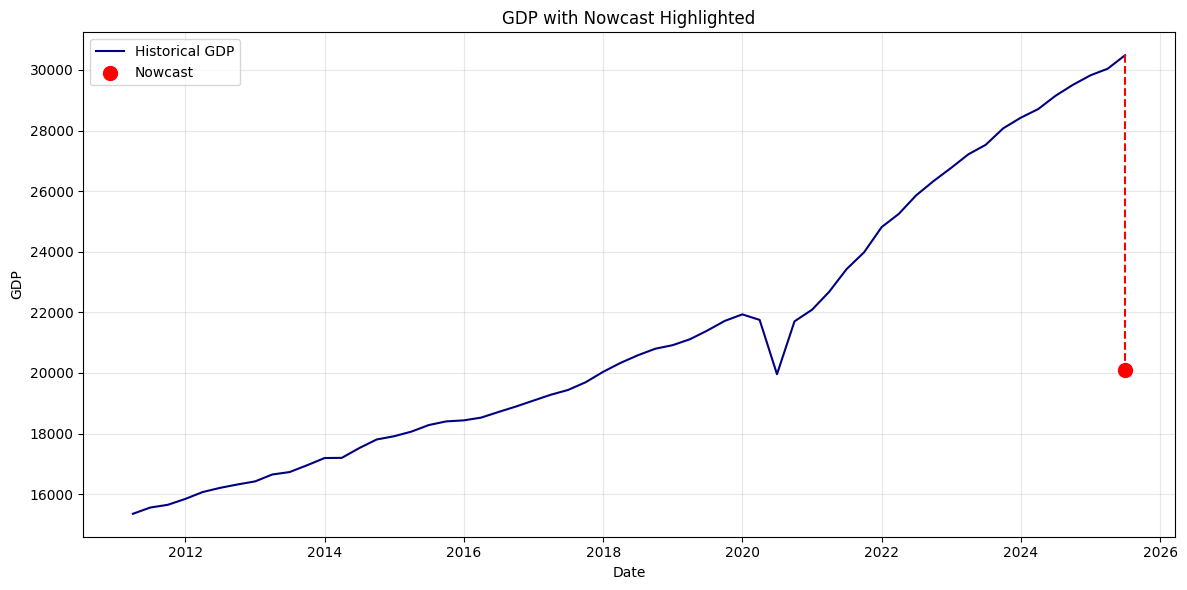

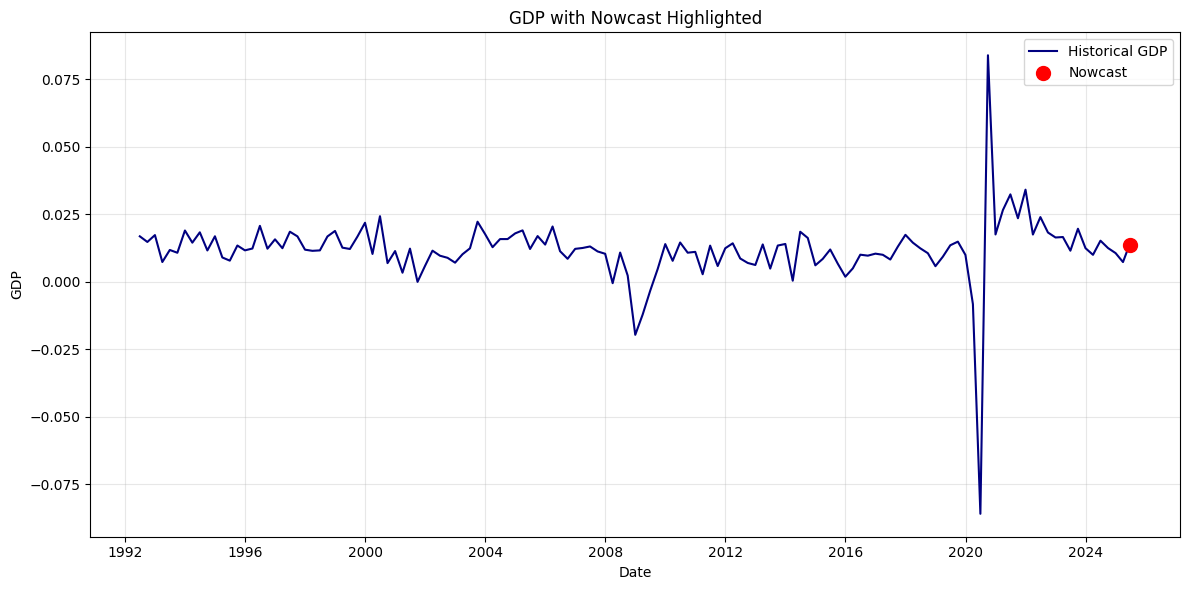

In [140]:
nowcast_date = pd.to_datetime("2025-06-30")
nowcast_series = pd.Series([nowcast_value], index=[nowcast_date])


plt.figure(figsize=(12, 6))

# plot historical GDP
plt.plot(data_filt.index, data_filt["gdp"], label="Historical GDP", color="navy")

# add the nowcast point
plt.scatter(nowcast_date, nowcast_value, 
            color="red", s=100, zorder=5, label="Nowcast")

# connect last point to nowcast
plt.plot([data_filt.index[-1], nowcast_date], 
         [data_filt["gdp"].iloc[-1], nowcast_value], 
         color="red", linestyle="--")

plt.title("GDP with Nowcast Highlighted")
plt.xlabel("Date")
plt.ylabel("GDP")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()




nowcast_date_2 = pd.to_datetime("2025-06-30")
nowcast_series_2 = pd.Series([nowcast_date_2], index=[nowcast_date_2])


plt.figure(figsize=(12, 6))

# plot historical GDP
plt.plot(data2_filt.index, data2_filt["gdp_growth"], label="Historical GDP", color="navy")

# add the nowcast point
plt.scatter(nowcast_date_2, nowcast_value_2, 
            color="red", s=100, zorder=5, label="Nowcast")

# connect last point to nowcast
plt.plot([data2_filt.index[-1], nowcast_date_2], 
         [data2_filt["gdp_growth"].iloc[-1], nowcast_value_2], 
         color="red", linestyle="--")

plt.title("GDP with Nowcast Highlighted")
plt.xlabel("Date")
plt.ylabel("GDP")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()





**Interpretation:**
The second ARIMAX model improved because it uses GDP growth instead of the large GDP level numbers. GDP growth shows how much the economy changes each quarter (for example 1% or 2%), and this is easier for the model to learn. All the other predictors are also in growth or change form (industrial production, retail sales, personal income, unemployment claims, sentiment, and housing), so they move in a similar way and make the model more stable.

The model fits the data very well. The AIC and BIC values are very low (about –974 and –948), which means this version explains the data better than models using GDP levels. The coefficient for industrial production growth is strong and positive, and its p-value is basically 0, so it is clearly an important driver of GDP growth. Retail sales growth is also significant, and its positive sign makes sense: when consumers spend more, the economy improves. Unemployment claims are significant too, and because we flipped the sign, the interpretation is correct: when claims fall, GDP growth usually rises. Personal income has a small negative effect, but it is statistically significant.

Some predictors like sentiment and housing are not significant, but keeping them still adds economic meaning. The AR and MA terms are stable, and the diagnostic tests (Ljung-Box and residual checks) show that the model does not suffer from major autocorrelation problems.

Now let's try automatically choosing the order values based on the AIC.

In [141]:
auto = pm.auto_arima(
    y, 
    exogenous=X, 
    seasonal=False,
    stepwise=True
)

auto.summary()
order = auto.order

In [142]:
print(order)

(0, 2, 1)


A 0 order for the autoregressive component is kind of shocking? Perhaps it's very highly correlated with our regressors.

In [143]:
# model
arimax_auto_ord = sm.tsa.SARIMAX(
    y,
    exog=X,
    order=order,   # all order 1 works well for many models
    enforce_stationarity=False,
    enforce_invertibility=False
)

# fit
fitted_arimax_auto_ord = arimax_auto_ord.fit()
print(fitted_arimax_auto_ord.summary())

                               SARIMAX Results                                
Dep. Variable:                    gdp   No. Observations:                   58
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -320.462
Date:                Thu, 20 Nov 2025   AIC                            662.924
Time:                        20:56:17   BIC                            684.803
Sample:                    03-31-2011   HQIC                           671.362
                         - 06-30-2025                                         
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
orders                 0.3521      0.651      0.541      0.589      -0.924       1.629
employment             0.0022      0.004      0.585      0.559      -0.005       0.010
consumer_sentiment  

Nowcasted GDP: 27960.829533536733
95% CI:
lower gdp    27774.685567
upper gdp    28146.973500
Name: 2025-09-30 00:00:00, dtype: float64


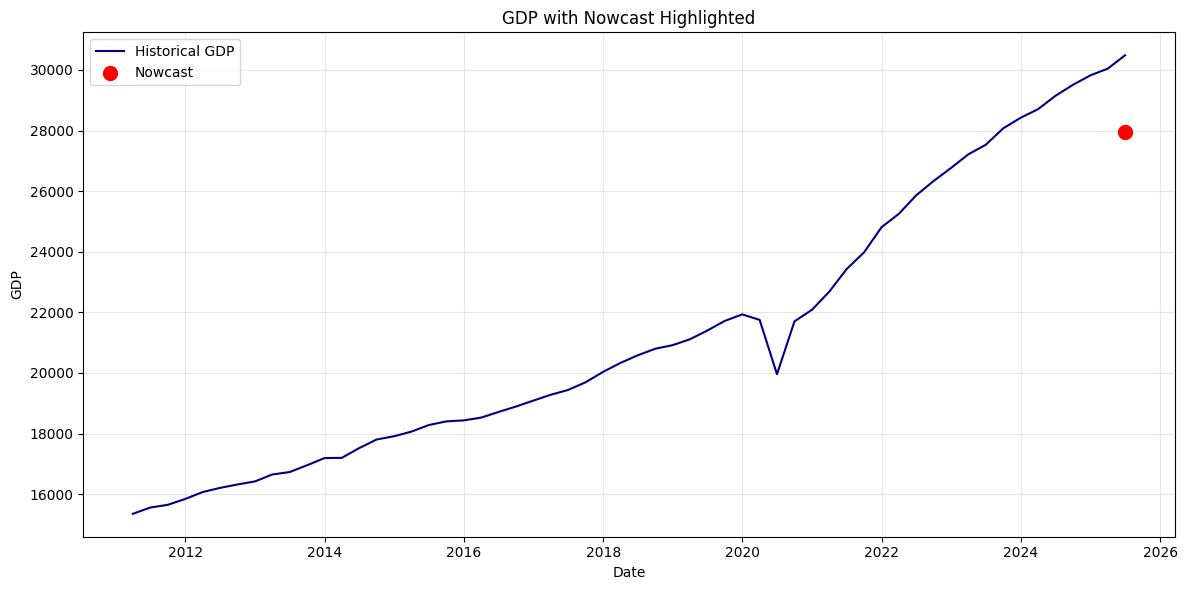

In [144]:
nowcast_auto = fitted_arimax_auto_ord.get_forecast(steps=1, exog=X_next)
nowcast_auto_value = nowcast_auto.predicted_mean.iloc[0]
nowcast_auto_ci = nowcast_auto.conf_int().iloc[0]

print("Nowcasted GDP:", nowcast_auto_value)
print("95% CI:")
print(nowcast_auto_ci)


nowcast_auto_series = pd.Series([nowcast_auto_value], index=[nowcast_date])


plt.figure(figsize=(12, 6))

# plot historical GDP
plt.plot(data_filt.index, data_filt["gdp"], label="Historical GDP", color="navy")

# add the auto chosen nowcast point
plt.scatter(nowcast_date, nowcast_auto_series, 
            color="red", s=100, zorder=5, label="Nowcast")


plt.title("GDP with Nowcast Highlighted")
plt.xlabel("Date")
plt.ylabel("GDP")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

These predictions are horrible. Let's try just a simple ARIMA (all the regressors could be clogging up the model).

In [145]:
y = data_filt["gdp"]

# simple ARIMA model — start with all ones
arima_ones = sm.tsa.ARIMA(y, order=(1, 1, 1))
arima_ones_fitted = arima_ones.fit()

print(arima_ones_fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                    gdp   No. Observations:                   58
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -420.563
Date:                Thu, 20 Nov 2025   AIC                            847.126
Time:                        20:56:18   BIC                            853.256
Sample:                    03-31-2011   HQIC                           849.508
                         - 06-30-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.002    589.808      0.000       0.997       1.003
ma.L1         -0.9971      0.069    -14.405      0.000      -1.133      -0.861
sigma2       1.47e+05   4.83e-07   3.04e+11      0.0

Now to forecast. 

In [146]:
forecast_arima = arima_ones_fitted.get_forecast(steps=1)
nowcast_value_arima = forecast_arima.predicted_mean.iloc[0]
nowcast_ci_arima = forecast_arima.conf_int().iloc[0]


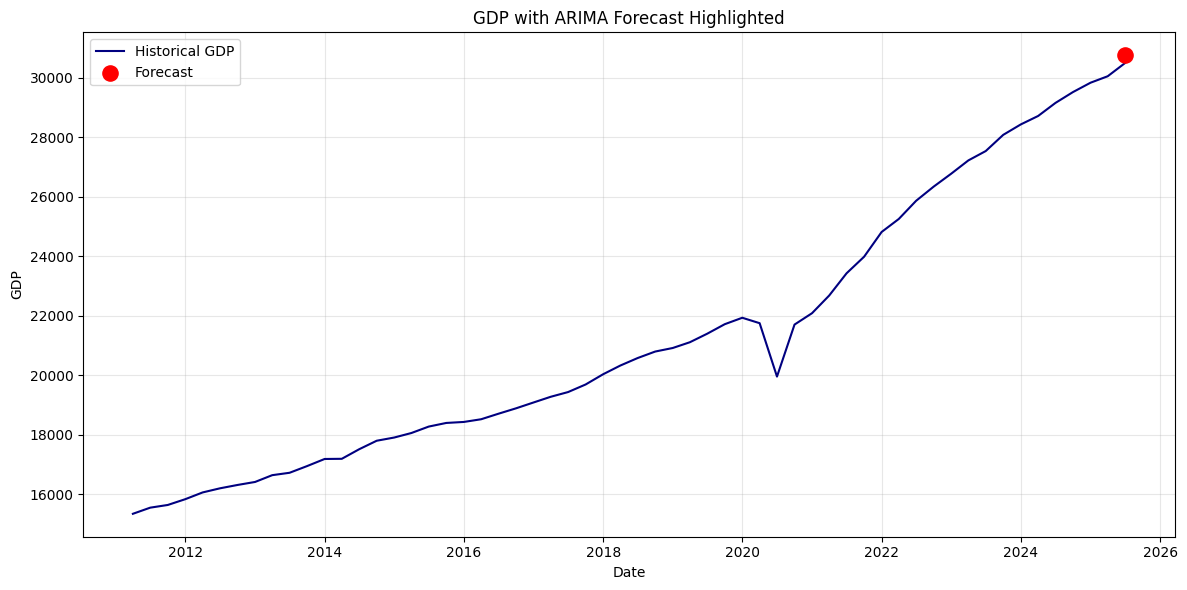

In [147]:
# make a Series for the forecasted value
nowcast_arima_series = pd.Series([nowcast_value_arima], index=[nowcast_date])

plt.figure(figsize=(12, 6))

# plot historical GDP
plt.plot(y.index, y, label="Historical GDP", color="navy")

# plot the forecast point
plt.scatter(nowcast_date, nowcast_value_arima,
            color="red", s=120, zorder=5, label="Forecast")

# dotted line connecting last real value to the forecast
plt.plot([y.index[-1], nowcast_date],
         [y.iloc[-1], nowcast_value_arima],
         color="red", linestyle="--")

plt.title("GDP with ARIMA Forecast Highlighted")
plt.xlabel("Date")
plt.ylabel("GDP")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
